# Copula - Multivariate joint distribution

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats

sns.set_style("darkgrid")
sns.mpl.rc("figure", figsize=(8, 8))

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

When modeling a system, there are often cases where multiple parameters are involved. Each of these parameters could be described with a given Probability Density Function (PDF). If would like to be able to generate a new set of parameter values, we need to be able to sample from these distributions-also called marginals. There are mainly two cases: *(i)* PDFs are independent; *(ii)* there is a dependency. One way to model the dependency it to use a **copula**.

## Sampling from a copula

Let's use a bi-variate example and assume first that we have a prior and know how to model the dependence between our 2 variables.

In this case, we are using the Gumbel copula and fix its hyperparameter `theta=2`. We can visualize it's 2-dimensional PDF.

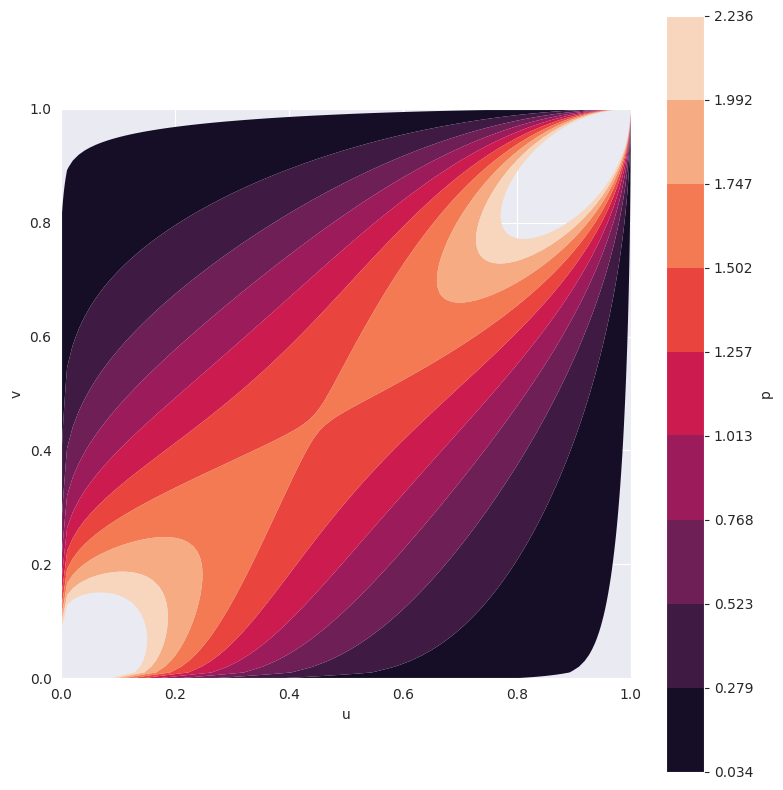

In [3]:
from statsmodels.distributions.copula.api import (
    CopulaDistribution, GumbelCopula, IndependenceCopula)

copula = GumbelCopula(theta=2)
_ = copula.plot_pdf()  # returns a matplotlib figure

And we can sample the PDF.

/opt/hostedtoolcache/Python/3.10.12/x64/lib/python3.10/site-packages/statsmodels/tools/rng_qrng.py:54: FutureWarning: Passing `None` as the seed currently return the NumPy singleton RandomState
(np.random.mtrand._rand). After release 0.13 this will change to using the
default generator provided by NumPy (np.random.default_rng()). If you need
reproducible draws, you should pass a seeded np.random.Generator, e.g.,

import numpy as np
seed = 32839283923801
rng = np.random.default_rng(seed)"

  warnings.warn(_future_warn, FutureWarning)


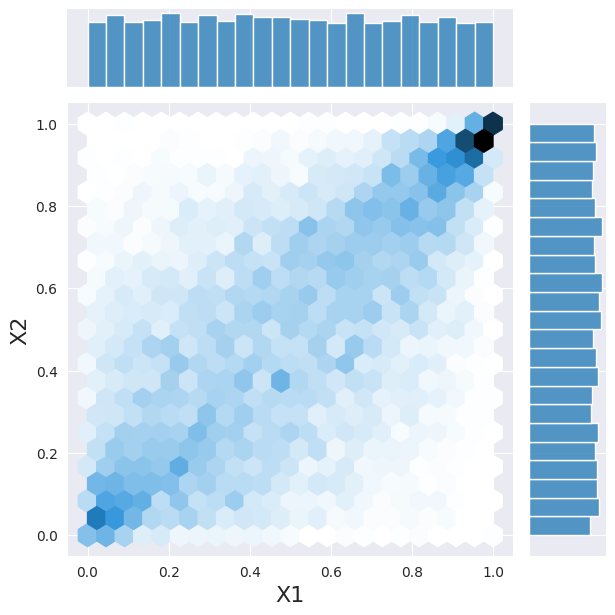

In [4]:
sample = copula.rvs(10000)
h = sns.jointplot(x=sample[:, 0], y=sample[:, 1], kind="hex")
_ = h.set_axis_labels("X1", "X2", fontsize=16)

Let's come back to our 2 variables for a second. In this case we consider them to be gamma and normally distributed. If they would be independent from each other, we could sample from each PDF individually. Here we use a convenient class to do the same operation.

### Reproducibility

Generating reproducible random values from copulas required explicitly setting the `seed` argument.
`seed` accepts either an initialized NumPy `Generator` or `RandomState`, or any argument acceptable
to `np.random.default_rng`, e.g., an integer or a sequence of integers. This example uses an
integer.

The singleton `RandomState` that is directly exposed in the `np.random` distributions is
not used, and setting `np.random.seed` has no effect on the values generated.

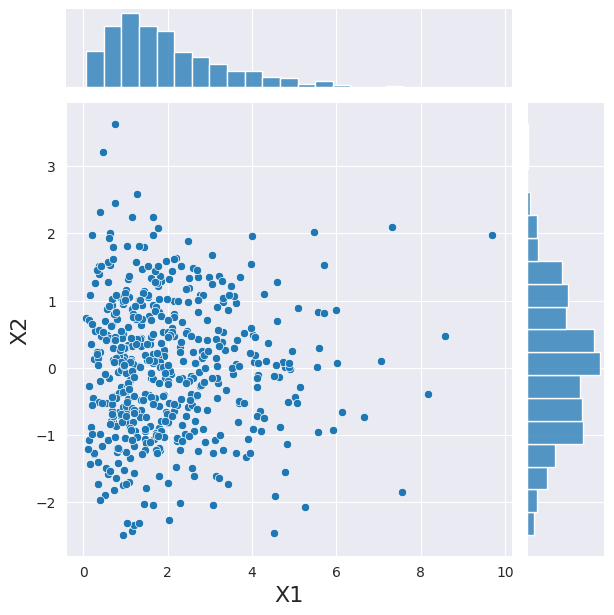

In [5]:
marginals = [stats.gamma(2), stats.norm]
joint_dist = CopulaDistribution(copula=IndependenceCopula(), marginals=marginals)
sample = joint_dist.rvs(512, random_state=20210801)
h = sns.jointplot(x=sample[:, 0], y=sample[:, 1], kind="scatter")
_ = h.set_axis_labels("X1", "X2", fontsize=16)

Now, above we have expressed the dependency between our variables using a copula, we can use this copula to sample a new set of observation with the same convenient class.

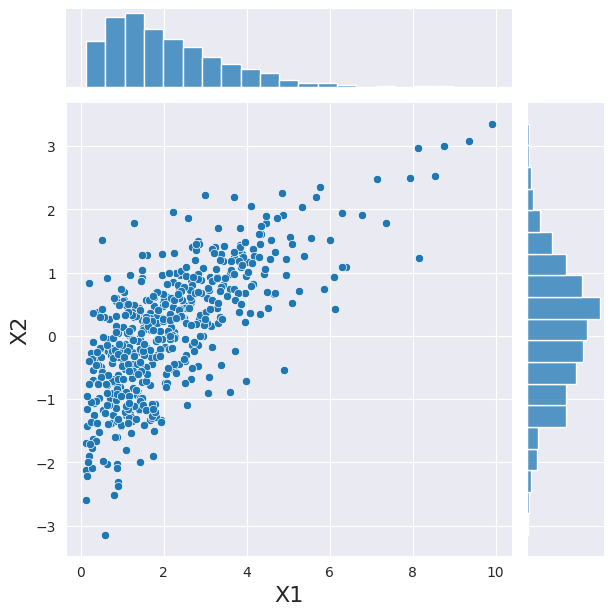

In [6]:
joint_dist = CopulaDistribution(copula, marginals)
# Use an initialized Generator object
rng = np.random.default_rng([2, 0, 2, 1, 0, 8, 0, 1])
sample = joint_dist.rvs(512, random_state=rng)
h = sns.jointplot(x=sample[:, 0], y=sample[:, 1], kind="scatter")
_ = h.set_axis_labels("X1", "X2", fontsize=16)

There are two things to note here. *(i)* as in the independent case, the marginals are correctly showing a gamma and normal distribution; *(ii)* the dependence is visible between the two variables.

## Estimating copula parameters

Now, imagine we already have experimental data and we know that there is a dependency that can be expressed using a Gumbel copula. But we don't know what is the hyperparameter value for our copula. In this case, we can estimate the value.

We are going to use the sample we just generated as we already know the value of the hyperparameter we should get: `theta=2`.

In [7]:
copula = GumbelCopula()
theta = copula.fit_corr_param(sample)
print(theta)

2.049379621506455


We can see that the estimated hyperparameter value is close to the value set previously.